# 2B06 neutralization assay
This analysis notebook analyses the neutralization assay data testing the potency of antibody D045-051310-2B06 to neutralize A/WSN/1933 H1N1 virus.

The assays are assumed to be in 96-well plates, with a different sample
type in each of the 8 rows (A to H) and the serum diluted across the 12
columns (1 to 12). The highest serum concentration is in column 12 and
it is serially diluted down to the lowest concentration in column 1. The
samples are as follows:

> * there are three replicates of the same virus
>   and serum in rows D, E, and F

> * rows C and G have the no-serum control
>   used to establish the maximal signal in the absence of neutralization -
>   row B has the virus-only control used to establish the background signal
>   expected at full neutralization

> * rows A and H have a media-only control
>   that should have very low signal (these rows can also be empty)

## Import Python packages¶
First, import the necessary Python modules. In addition to the neutcurve package itself, we also use pandas to hold the data and pyyaml to parse the YAML configuration file:

In [1]:
import os

import pandas as pd

import yaml

import neutcurve
import neutcurve.parse_excel

Set output format of pandas Data Frames

In [2]:
pd.set_option('display.float_format', '{:.3g}'.format)

# Specify configuration of data

In order to parse the raw experimental data in the Excel files, we need
to describe how they are configured. The data can consist of one or more
Excel files, each of which may have one or more sheets. Each sheet
specifies three replicates of a virus against a serum as described
above.

In order to parse an Excel file, we need to supply the information taken
by `neutcurve.parse_excel.parseRachelStyle2019()`. As described in
the docs for that function, for each Excel file we need:

* *excelfile*: the name of the Excel file

* *sheet_mapping*: a dictionary keyed be the name of each sheet in
  *excelfile* which in turn specifies:

  * ‘serum’: name of serum

  * ‘virus’: name of virus

  * ‘initial_concentration’: highest concentration of serum

  * ‘dilution_factor’: dilution factor in serial dilutions of serum

You can specify this information in a [YAML
format](https://docs.ansible.com/ansible/latest/reference_appendices/YAMLSyntax.html)
file.

In [3]:
config_file = 'data/neut_data/2B06_neut_022019.yaml'

<!-- Next cell sets right file path if running with pytest from top directory. -->
Here are the contents of the YAML configuration file.

In [4]:
with open(config_file) as f:
    print(f.read().strip())

- 20Feb19:
    excelfile: data/neut_data/2B06_neut_analysis.xlsx
    sheet_mapping:
      2B06_WSN_wt:
        serum: 2B06
        virus: A/WSN/1933
        dilution_factor: 5
        initial_concentration: 200


We also need to specify the output directory where the results are
written:

In [5]:
outdir = 'results/neut_assays/'
os.makedirs(outdir, exist_ok=True)

# Read the data from the Excel files

Now we read in the configuration specified in our *config_file* into the
variable *config*, which will be a list of dicts:

In [6]:
with open(config_file) as f:
    config = yaml.safe_load(f)

<!-- Next cell sets right excelfile path if running with pytest from top directory. -->
Next, for each dict in *config*, we use
`neutcurve.parse_excel.parseRachelStyle2019()` to create a tidy
data frame appropriate for passing to
`neutcurve.curvefits.CurveFits` as described in Fitting curves to real data.
We then concatenate all the
tidy data frame to get our neutralization data:

In [7]:
neutdata = []  # store all data frame, then concatenate at end

for sampledict in config:
    assert len(sampledict) == 1
    sampleset, kwargs = list(sampledict.items())[0]
    print(f"Parsing data for {sampleset}...")
    neutdata.append(neutcurve.parse_excel.parseRachelStyle2019(**kwargs))

neutdata = pd.concat(neutdata)
print(f"Read data for {len(neutdata.groupby('serum'))} sera and "
      f"{len(neutdata.groupby(['serum', 'virus']))} serum / virus pairs.")

Parsing data for 20Feb19...
Read data for 1 sera and 1 serum / virus pairs.


We write the neutralization data to a CSV file in our output directory:

In [8]:
neutdatafile = os.path.join(outdir, 'neutdata.csv')
neutdata.to_csv(neutdatafile, index=False)
print(f"Wrote neutralization data to {neutdatafile}")

Wrote neutralization data to results/neut_assays/neutdata.csv


# Fit and analyze the curves

Now we can simply fit the data in *neutdata* with a
`neutcurve.curvefits.CurveFits` as in Fitting curves to real data:

In [9]:
fits = neutcurve.CurveFits(neutdata)

Make plots that show the curves for all replicates for each serum / virus combination:

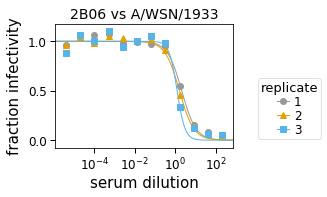

In [10]:
fig_reps, _ = fits.plotReplicates(legendtitle='replicate',
                                  xlabel='serum dilution')

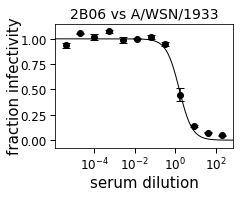

In [11]:
fig_avgs, _ = fits.plotAverages(xlabel='serum dilution')

Make plots that show all viruses for each serum. Note that for this
particular dataset, this plot isn’t really any different than the one
above–but we make it here because it will be different for datasets that
involve multiple different viruses:|

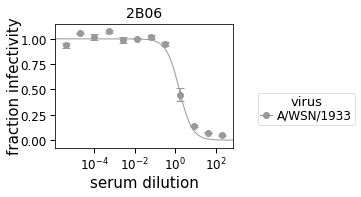

In [12]:
fig_sera, _ = fits.plotSera(legendtitle='virus',
                            xlabel='serum dilution')

Now we write all of the plots to PDF files:

In [13]:
for plotname, fig in [('replicates_plot', fig_reps),
                      ('average_plot', fig_avgs),
                      ('sera_plot', fig_sera)]:
    plotfile = os.path.join(outdir, plotname + '.pdf')
    print(f"Creating plot {plotfile}")
    fig.savefig(plotfile)

Creating plot results/neut_assays/replicates_plot.pdf
Creating plot results/neut_assays/average_plot.pdf
Creating plot results/neut_assays/sera_plot.pdf


We also look at the numerical values of the fit parameters, including the IC50s:

In [14]:
fits.fitParams()

,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,midpoint,slope,top,bottom
0,2B06,A/WSN/1933,average,3,1.54,interpolated,1.54,1.54,1.37,1,0


We write these fit parameters to a CSV file:

In [15]:
fitfile = os.path.join(outdir, 'fitparams.csv')
fits.fitParams().to_csv(fitfile, index=False)
print(f"Wrote fit parameters to {fitfile}")

Wrote fit parameters to results/neut_assays/fitparams.csv


So overall, this analysis has created several plots and CSV files in
*outdir*:

In [16]:
print(f"Here are the created files in {outdir}:\n  " +
      '\n  '.join(sorted(os.listdir(outdir))))

Here are the created files in results/neut_assays/:
  average_plot.pdf
  fitparams.csv
  neutdata.csv
  replicates_plot.pdf
  sera_plot.pdf
